In [1]:
import json
import os
import time

from fastcluster import linkage
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import DBSCAN, AgglomerativeClustering

In [2]:
def read_jsonl(path):
    """Parse jsonl to list of dicts"""
    with open(path) as f:
        lines = f.readlines()
    return [json.loads(line) for line in lines]


def get_signatures(ap_results):
    """Given the author profile results get all signatures"""
    signatures = []
    for profile in ap_results:
        signatures += profile['signatureIds']
    return signatures


def fill_dmatrix(distances, signature_list):
    """Given distances jsonl and list of signatures fill the distance matrix"""
    dmatrix = np.zeros(shape=(len(signature_list), len(signature_list)))

    signature_to_idx = {
        signature: idx for idx, signature in enumerate(signature_list)
    }

    for distance in distances:
        sig1 = distance['signatureId1']
        sig2 = distance['signatureId2']
        d = distance['distance']
        row = signature_to_idx[sig1]
        column = signature_to_idx[sig2]
        dmatrix[row, column] = d

    dmatrix = dmatrix.T + dmatrix # Transpose to fill symetric elements
    return dmatrix, signature_to_idx


def get_features(sig_id, features):
    """Retrieve all feature vectors realated to the given signature"""
    feature_vectors = []
    for feature_entry in features:
        if feature_entry['signatureId1'] == sig_id or feature_entry['signatureId2'] == sig_id:
            feature_vectors.append(feature_entry['features'])
    return feature_vectors

In [3]:
AUTHOR_PATH = '../data/rcohen/'

In [4]:
ap_results = read_jsonl(path=os.path.join(AUTHOR_PATH, 'results.json'))
distances = read_jsonl(path=os.path.join(AUTHOR_PATH, 'distances.json'))
signatures = get_signatures(ap_results)
dmatrix, signature_to_idx = fill_dmatrix(distances, signatures)

In [44]:
durations = []

clusterer = DBSCAN(eps=0.08025, min_samples=2, metric='precomputed')
t0 = time.time()
_ = clusterer.fit_predict(dmatrix)
t1 = time.time()

durations.append(t1-t0)
print(f'Clustering with DBSCAN lasts {(t1-t0):.2f} seconds')

Clustering with DBSCAN lasts 1.48 seconds


In [45]:
clusterer = AgglomerativeClustering(
    n_clusters=None,
    affinity='precomputed',
    distance_threshold=0.52502,
    linkage='average'
)
t0 = time.time()
sklearn_profiles = clusterer.fit_predict(dmatrix)
t1 = time.time()

durations.append(t1-t0)
print(f'Clustering with AgglomerativeClustering lasts {(t1-t0):.2f} seconds')

Clustering with AgglomerativeClustering lasts 7.00 seconds


In [46]:
condensed_dmatrix = dmatrix[np.triu_indices(n=dmatrix.shape[0], k=1)]

t0 = time.time()
Z = linkage(condensed_dmatrix, method='average')
fastcluster_profiles = fcluster(Z, t=0.52502, criterion='distance')
t1 = time.time()

durations.append(t1-t0)
print(f'Clustering with Fastcluster lasts {(t1-t0):.2f} seconds')

Clustering with Fastcluster lasts 1.75 seconds


In [47]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(labels_true=sklearn_profiles, labels_pred=fastcluster_profiles)
nmi = normalized_mutual_info_score(labels_true=sklearn_profiles, labels_pred=fastcluster_profiles)

print(f'ARI: {ari}')
print(f'NMI: {nmi}')

ARI: 1.0
NMI: 1.0


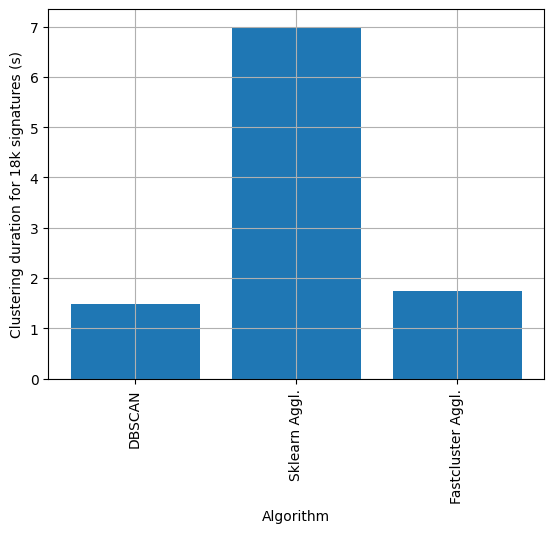

In [50]:
plt.bar(x=range(len(durations)), height=durations)
plt.grid()
plt.xlabel('Algorithm')
plt.ylabel('Clustering duration for 18k signatures (s)')
plt.xticks(ticks=range(len(durations)), labels=['DBSCAN', 'Sklearn Aggl.', 'Fastcluster Aggl.'], rotation=90)
plt.show()